In [1]:
SCHOOL="stanford"
SUBJECT="opinions"
START_YEAR=2010
FINAL_YEAR=2022
TOPIC_EMBEDDING_MODEL = "all-MiniLM-L6-v2" # alt: "all-mpnet-base-v2"
DATA_DIR="data"      # should be 'data'
OUTPUT_DIR="output"  # should be 'output'

In [2]:
import math
import os
import numpy as np
import pandas as pd

import nltk
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_lg")

2023-01-25 22:43:18.743957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges/notebooks'

In [4]:
# NOTE: for input data & outputs to work, we need to be in the main project folder
%cd ..

/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges


In [5]:
import sys
sys.path.append('src')
import ouraws
import ourgraphs
import textutil

In [6]:
# NOTE: before loading, we need to be in the "collegier" folder

S3OBJECT_KEY = f"{DATA_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [7]:
df.shape

(4914, 6)

In [8]:
df.columns

Index(['title', 'url', 'body', 'year', 'month', 'day'], dtype='object')

In [9]:
df["year"].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022])

In [10]:
RESULTS_OUTPUT = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-diversity-results.parquet"

In [12]:
if os.path.exists(RESULTS_OUTPUT):
    results_df = pd.read_parquet(RESULTS_OUTPUT)
else:
    print(f"You have not run the experiment yet: {RESULTS_OUTPUT}")

You have not run the experiment yet: output/stanford-opinions-diversity-results.parquet


In [ ]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]

    if year_df.shape[0] > 0:
        docs_df, num_diversity_words = textutil.filterText(year_df.body) 
        wv = [nlp(s) for s in docs_df]
        docvecs = np.array([v.vector for v in wv])
        
        pairwise = textutil.getNormalizedPairwiseDispersion(docvecs)
        cov = textutil.getCovDispersion(docvecs)
        
        print("{:<10}{:<10}{:<10}{:<10.3e}{:<10.3e}{:<10.3e}{:<10.3f}".format(
            year, cov[0], num_diversity_words, cov[1], cov[2], cov[3], pairwise
        ))

        result = {'year':       year,
                'mentions': num_diversity_words,
                'pairwise':     pairwise,
                'size':         cov[0],
                'trace':        cov[1],
                'norm-1':       cov[2], 
                'norm-2':       cov[3], 
                'norm-inf':     cov[4], 
                }
        results.append(result)

2010      506       568       1.630e+00 1.745e+00 1.496e+00 0.083     
2011      482       587       1.645e+00 1.783e+00 1.505e+00 0.086     
2012      457       534       1.647e+00 1.749e+00 1.522e+00 0.077     
2013      340       474       1.671e+00 1.762e+00 1.562e+00 0.066     


In [23]:
results_df = pd.DataFrame.from_records(results)

In [10]:
results_df['mention-norm'] = results_df['mentions'] / results_df['size']
results_df.set_index('year')

,mentions,pairwise,size,trace,norm-1,norm-2,norm-inf,mention-norm
year,,,,,,,,
2010,568,0.082825,506,1.629681,1.745139,1.496241,1.745139,1.122530
2011,587,0.086433,482,1.645288,1.782941,1.505157,1.782941,1.217842
2012,534,0.076713,457,1.647179,1.748914,1.522181,1.748914,1.168490
2013,474,0.066163,340,1.671423,1.762056,1.562429,1.762056,1.394118
2014,628,0.060664,455,1.713245,1.803169,1.611156,1.803169,1.380220
2015,680,0.060481,447,1.737944,1.867938,1.634923,1.867938,1.521253
2016,634,0.067081,408,1.689728,1.883853,1.580809,1.883853,1.553922
2017,659,0.064844,427,1.720610,1.890495,1.611194,1.890495,1.543326
2018,586,0.068001,367,1.704076,1.890135,1.590267,1.890135,1.596730


In [31]:
results_df.to_parquet(RESULTS_OUTPUT)

## Diversity Word Mentions vs Diversity of Ideas

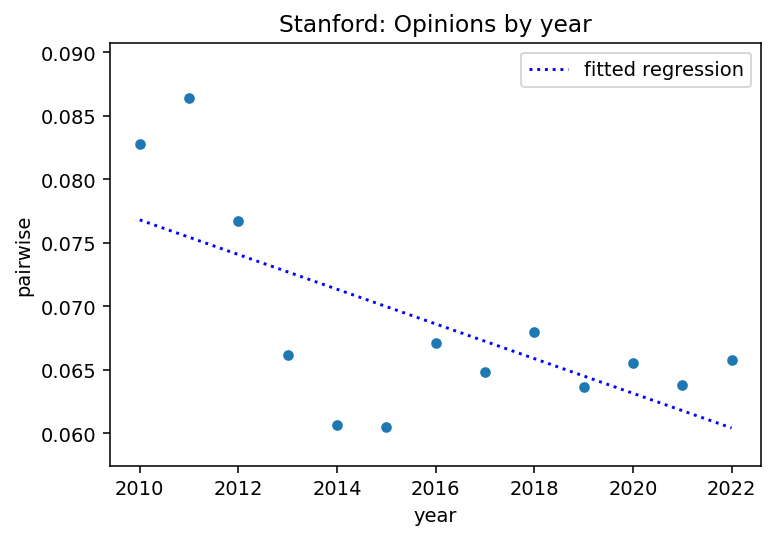

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a line plot of the data
results_df.plot(x="year", y="pairwise", kind="scatter")

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Stanford: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mention-norm slope:0.07692, int:1.08375, r:0.91633, p-value:0.00001, se:0.01013, x:range(0, 13)
pairwise slope:-0.00137, int:0.07681, r:-0.65040, p-value:0.01609, se:0.00048, x:range(0, 13)
trace slope:0.00356, int:1.66344, r:0.40293, p-value:0.17222, se:0.00244, x:range(0, 13)
norm-1 slope:0.00637, int:1.78306, r:0.41456, p-value:0.15900, se:0.00422, x:range(0, 13)
norm-2 slope:0.00559, int:1.53787, r:0.50260, p-value:0.08003, se:0.00290, x:range(0, 13)
norm-inf slope:0.00637, int:1.78306, r:0.41456, p-value:0.15900, se:0.00422, x:range(0, 13)


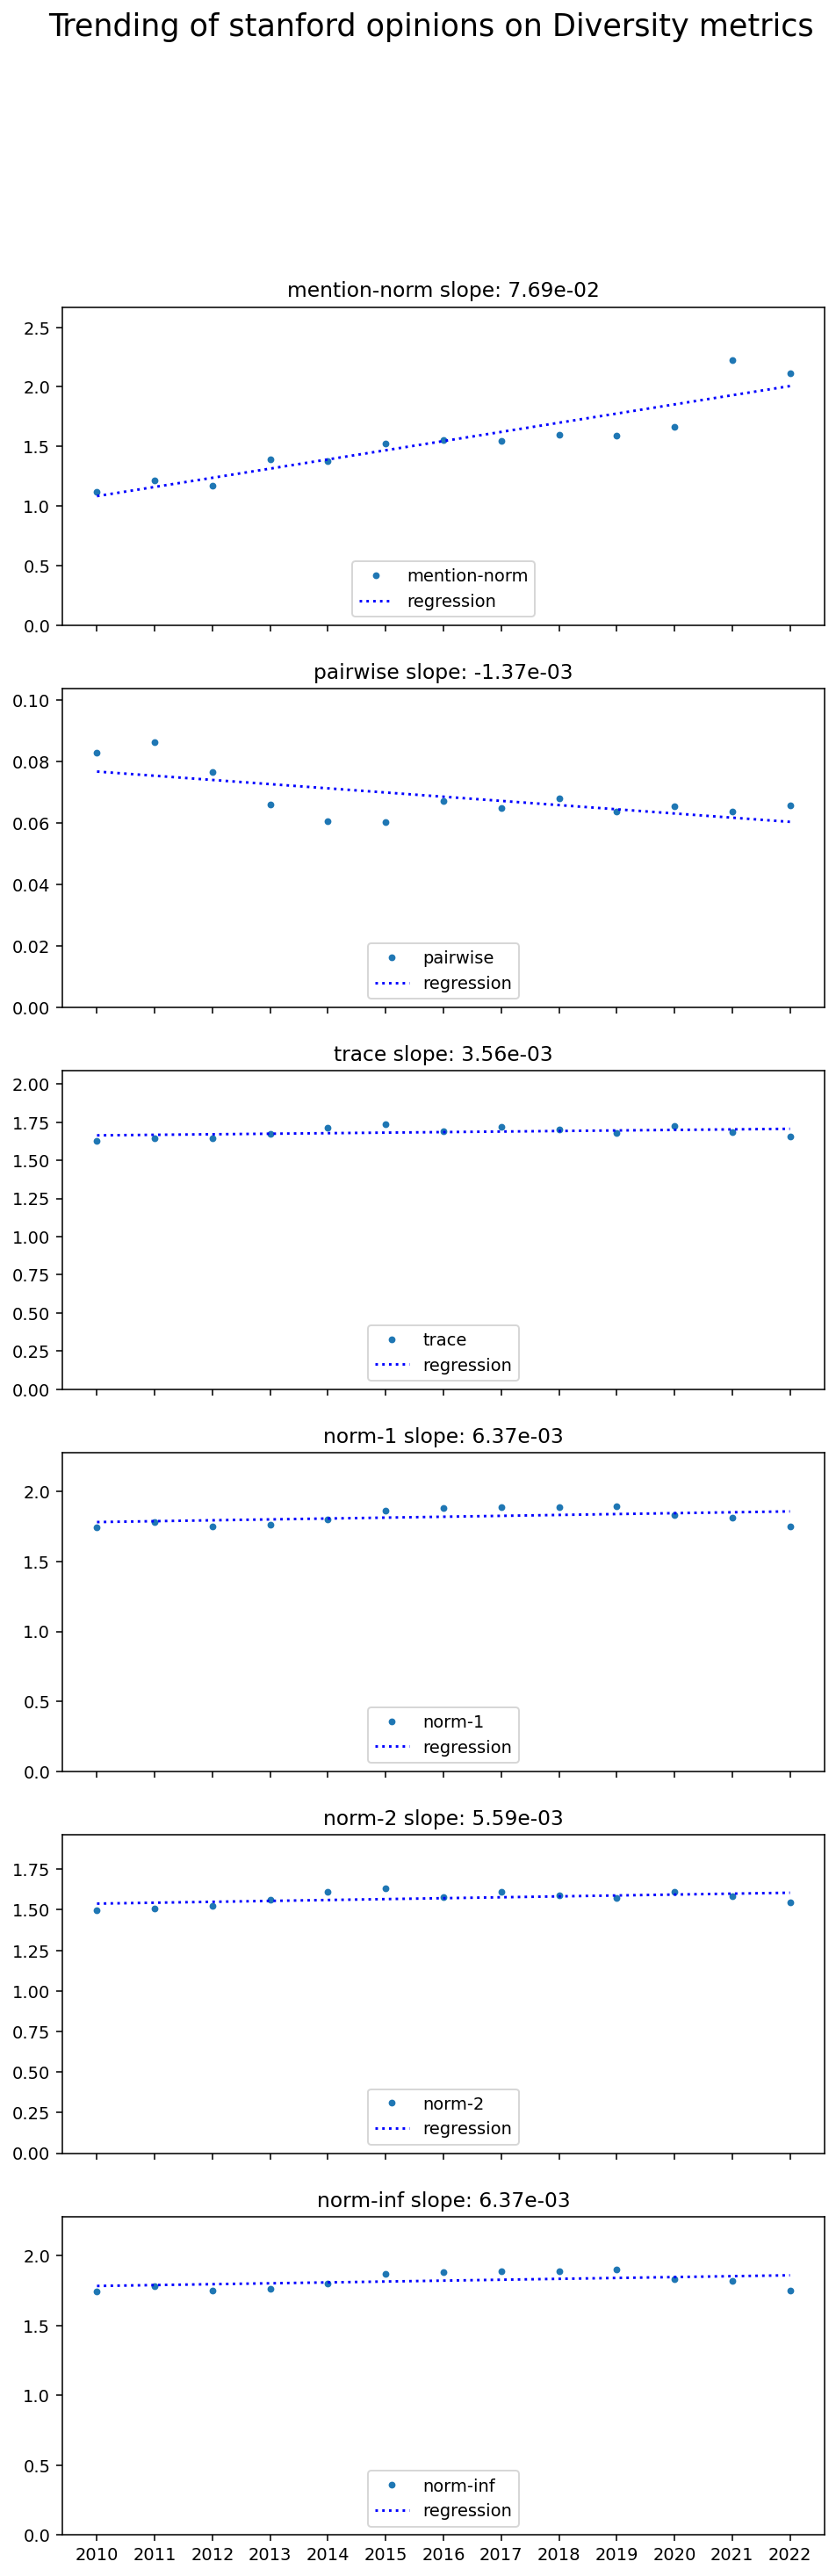

In [32]:
title = "Trending of {} {} on Diversity metrics".format(
    SCHOOL, SUBJECT
)
columns = ["mention-norm", "pairwise", "trace", "norm-1", "norm-2", "norm-inf"]
graph = ourgraphs.showTopicsResults(results_df, title, columns)
graph.show()

mention-norm slope:0.07692, int:1.08375, r:0.91633, p:0.00001, se:0.01013, x:range(0, 13)
pairwise slope:-0.00137, int:0.07681, r:-0.65040, p:0.01609, se:0.00048, x:range(0, 13)


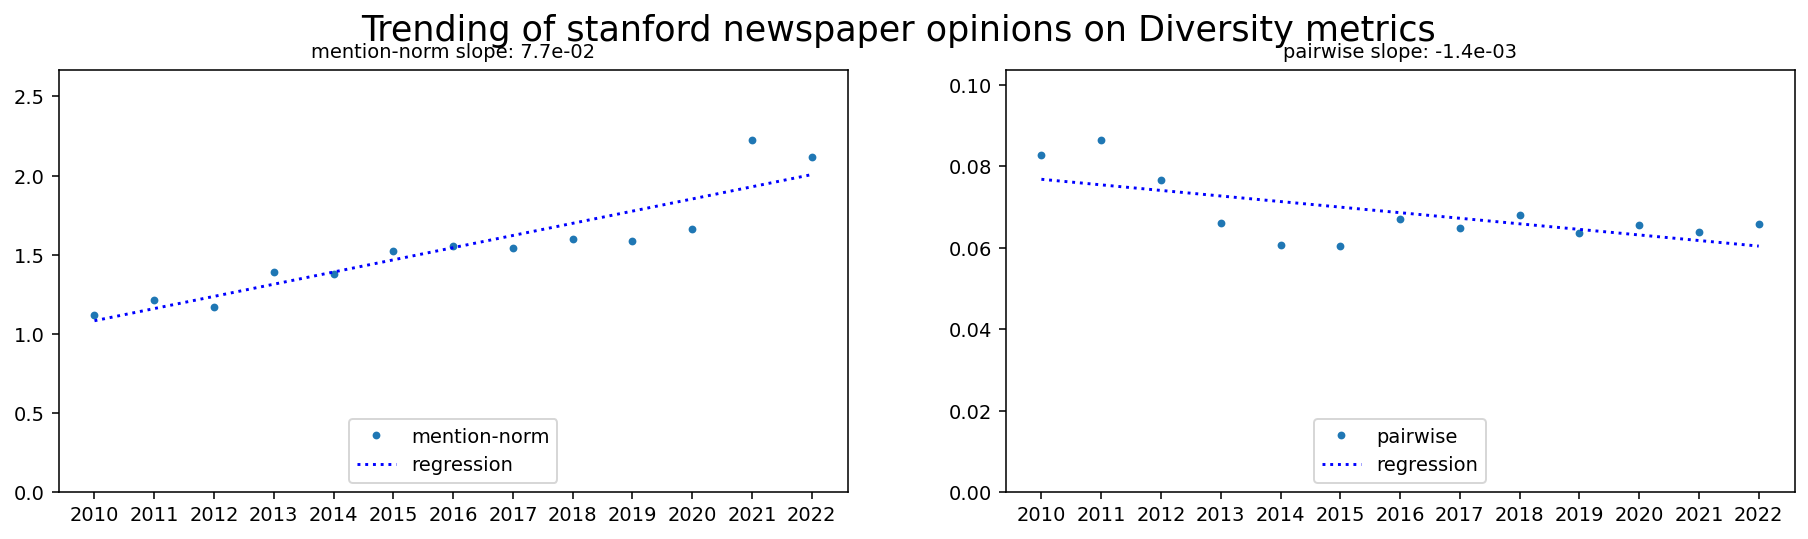

In [33]:
title = "Trending of {} newspaper {} on Diversity metrics\n".format(
    SCHOOL, SUBJECT
)
columns = ["mention-norm", "pairwise"]
graph = ourgraphs.showKeyTopicsResults(results_df, title, columns)
graph.show()

## Topic Modeling

In [13]:
from bertopic import BERTopic

BERTOPIC_FILENAME = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-BERTopic-model"
# to load a saved one: 
topic_model = BERTopic.load(BERTOPIC_FILENAME)

# if os.path.exists(BERTOPIC_FILENAME):
#     print("Are you sure that you don't want to load a saved transformer? ")
# else:
# topic_model = BERTopic(embedding_model=TOPIC_EMBEDDING_MODEL)

In [18]:
all_docs, num_diversity_words = textutil.filterText(df.body)

In [36]:
# This is a very EXPENSIVE operation: do it with care!
# Alternatively, load it with SentenceTransformer (see above)
topics, probs = topic_model.fit_transform(all_docs.to_list())

In [37]:
topic_model.save(BERTOPIC_FILENAME)

In [14]:
topic_info = topic_model.get_topic_info()
topic_info.shape

(85, 3)

In [15]:
topic_info.head(15)

,Topic,Count,Name
0,-1,1627,-1_the_stanford_daily_letter
1,0,268,0_climate_fossil_fuel_environmental
2,1,173,1_sexual_assault_sex_rape
3,2,152,2_trump_clinton_election_republican
4,3,150,3_food_meat_eating_dining
5,4,146,4_stanford_year_time_class
6,5,107,5_football_game_team_athlete
7,6,105,6_admission_student_college_school
8,7,92,7_daily_editor_the_vol
9,8,81,8_israel_israeli_palestinian_palestine


In [16]:
topic_model.get_topic(0)

[('climate', 0.01882758208048918),
 ('fossil', 0.015060612779002551),
 ('fuel', 0.012551391130639588),
 ('environmental', 0.011235821425141873),
 ('energy', 0.01106390811800055),
 ('water', 0.010778288860275854),
 ('change', 0.009828636448552676),
 ('oil', 0.008926577304251225),
 ('the', 0.00857312269581934),
 ('carbon', 0.008253538103075069)]

In [19]:
doc_info = topic_model.get_document_info(all_docs.to_list())
doc_info.head(15)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,sense nonsense: making dream reality | the sta...,-1,-1_the_stanford_daily_letter,the - stanford - daily - letter - diving - swi...,0.000000,False
1,the transitive property: the best birthday pre...,-1,-1_the_stanford_daily_letter,the - stanford - daily - letter - diving - swi...,0.000000,False
2,"sent from my iphone: father jim, deliver u fro...",-1,-1_the_stanford_daily_letter,the - stanford - daily - letter - diving - swi...,0.000000,False
3,letter editor | the stanford daily letter edit...,7,7_daily_editor_the_vol,daily - editor - the - vol - stanford - news -...,0.531817,False
4,op-ed: don’t you wish your ihum were hot like ...,-1,-1_the_stanford_daily_letter,the - stanford - daily - letter - diving - swi...,0.000000,False
5,op-ed: deflating latex bubble | the stanford d...,1,1_sexual_assault_sex_rape,sexual - assault - sex - rape - ix - title - s...,0.892938,False
6,op-ed: here’s the deal | the stanford daily op...,5,5_football_game_team_athlete,football - game - team - athlete - athletes - ...,1.000000,False
7,op-ed: a dry holiday east palo alto | the stan...,0,0_climate_fossil_fuel_environmental,climate - fossil - fuel - environmental - ener...,0.450196,False
8,op-ed: cc: lonelystanford@gmail.com | the stan...,43,43_duck_syndrome_harry_it,duck - syndrome - harry - it - one - mental - ...,1.000000,True
9,editorial: the age privacy | the stanford dail...,60,60_fizz_phishing_security_email,fizz - phishing - security - email - vulnerabi...,0.993316,False


### Visualize Topics

Call `.visualize_topics` to create a 2D representation of your topics. The resulting graph is a plotly interactive graph which can be converted to HTML:

In [52]:
topic_model.visualize_topics(width=1000, height=600)

### Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help to select an appropriate nr_topics when reducing the number of topics that you have created. To visualize this hierarchy, run the following:

In [21]:
topic_model.visualize_hierarchy()

### Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other. To visualize this hierarchy, run the following:

In [22]:
topic_model.visualize_barchart()

In [23]:
topic_model.visualize_term_rank()

## Topics over Time


In [24]:
all_docs, all_docs_years = textutil.filterTextWithYears(df.body, df.year)

In [25]:
topics_over_time = topic_model.topics_over_time(all_docs, all_docs_years)

In [38]:
topic_model.visualize_topics_over_time(topics_over_time, width=1080)

In [27]:
topics_over_time 

,Topic,Words,Frequency,Timestamp,Name
0,-1,"the, stanford, daily, it, swimming",194,2010,-1_the_stanford_daily_letter
1,0,"energy, climate, clean, global, oil",25,2010,0_climate_fossil_fuel_environmental
2,1,"sex, sexual, assault, yanran, std",14,2010,1_sexual_assault_sex_rape
3,2,"america, tea, party, palin, trump",5,2010,2_trump_clinton_election_republican
4,3,"food, farm, burrito, moonbean, dining",7,2010,3_food_meat_eating_dining
...,...,...,...,...,...
757,54,"abortion, gag, reproductive, helm, wade",1,2022,54_abortion_woman_pro_choice
758,60,"fizz, vulnerability, user, security, data",1,2022,60_fizz_phishing_security_email
759,63,"code, honor, cheating, judicial, student",1,2022,63_judicial_code_honor_charter
760,72,"stem, woman, female, gender, male",6,2022,72_stem_woman_female_gender


In [28]:
topics_over_time = topics_over_time[topics_over_time.Topic != -1]

In [29]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
1,0,"energy, climate, clean, global, oil",25,2010,0_climate_fossil_fuel_environmental
2,1,"sex, sexual, assault, yanran, std",14,2010,1_sexual_assault_sex_rape
3,2,"america, tea, party, palin, trump",5,2010,2_trump_clinton_election_republican
4,3,"food, farm, burrito, moonbean, dining",7,2010,3_food_meat_eating_dining
5,4,"stanford, year, time, it, the",16,2010,4_stanford_year_time_class
...,...,...,...,...,...
757,54,"abortion, gag, reproductive, helm, wade",1,2022,54_abortion_woman_pro_choice
758,60,"fizz, vulnerability, user, security, data",1,2022,60_fizz_phishing_security_email
759,63,"code, honor, cheating, judicial, student",1,2022,63_judicial_code_honor_charter
760,72,"stem, woman, female, gender, male",6,2022,72_stem_woman_female_gender


In [30]:
len(topic_model.topic_embeddings_[0])

384

### Extract topic embeddings for each year

In [63]:
results = []
for year in range(2011, 2023):
    topics_series = topics_over_time[topics_over_time.Timestamp==year].Topic
    
    topic_embeddings = []
    for topic in topics_series:
        topic_embeddings.append(topic_model.topic_embeddings_[topic])
    pairwise_measure = textutil.getNormalizedPairwiseDispersion(topic_embeddings)
    cov = textutil.getCovDispersion(topic_embeddings)
        
    results.append({
        'year': year,
        'topics_count': topics_series.nunique(),
        'size'        : df[df.year == year].shape[0],
        'topics_norm' : topics_series.nunique() / df[df.year == year].shape[0],
        'pairwise': pairwise_measure,
        'trace': cov[1],
        'norm-1': cov[2],
        'norm-2': cov[3],
        'norm-inf': cov[4]
    })
    
topics_trend_df = pd.DataFrame.from_records(results)

In [64]:
topics_trend_df.set_index('year')

,topics_count,size,topics_norm,pairwise,trace,norm-1,norm-2,norm-inf
year,,,,,,,,
2011,58,482,0.120332,0.417920,0.001217,0.000793,0.000709,0.000793
2012,60,457,0.131291,0.408834,0.001204,0.000801,0.000712,0.000801
2013,65,340,0.191176,0.413190,0.001197,0.000793,0.000703,0.000793
2014,70,455,0.153846,0.415377,0.001197,0.000783,0.000699,0.000783
2015,63,447,0.140940,0.414731,0.001217,0.000800,0.000712,0.000800
2016,63,408,0.154412,0.410793,0.001214,0.000800,0.000715,0.000800
2017,65,427,0.152225,0.405510,0.001206,0.000791,0.000715,0.000791
2018,65,367,0.177112,0.404033,0.001189,0.000794,0.000708,0.000794
2019,55,328,0.167683,0.425582,0.001222,0.000783,0.000703,0.000783


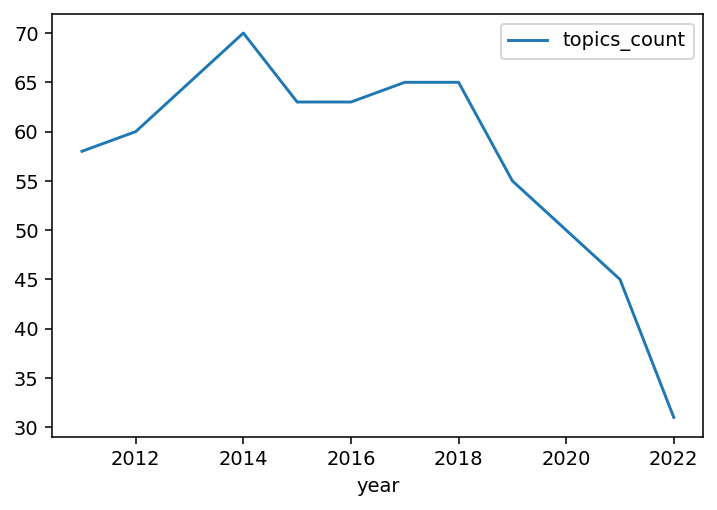

In [66]:
topics_trend_df.plot(x='year', y='topics_count', kind='line')

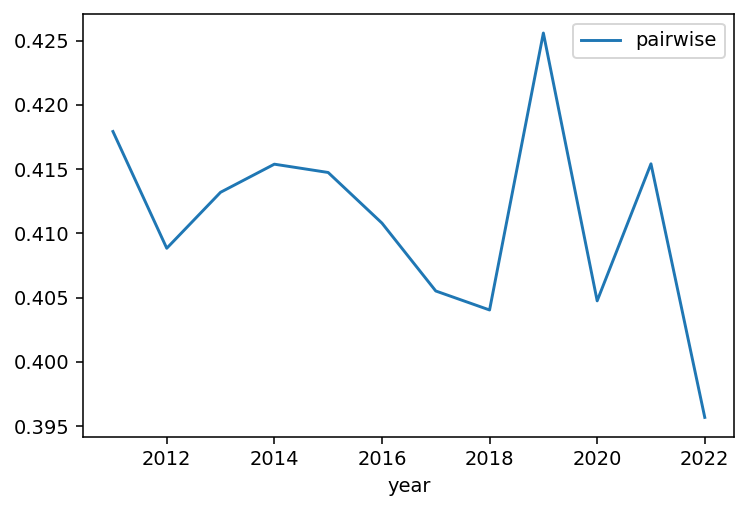

In [67]:
topics_trend_df.plot(x='year', y='pairwise', kind='line')

topics_count slope:-2.11189, int:69.11538, r:-0.69696, p-value:0.01177, se:0.68715, x:range(0, 12)
pairwise slope:-0.00081, int:0.41543, r:-0.37177, p-value:0.23407, se:0.00064, x:range(0, 12)
trace slope:0.00000, int:0.00120, r:0.45434, p-value:0.13786, se:0.00000, x:range(0, 12)
norm-1 slope:0.00000, int:0.00079, r:0.45013, p-value:0.14200, se:0.00000, x:range(0, 12)
norm-2 slope:0.00000, int:0.00070, r:0.61469, p-value:0.03342, se:0.00000, x:range(0, 12)
norm-inf slope:0.00000, int:0.00079, r:0.45013, p-value:0.14200, se:0.00000, x:range(0, 12)


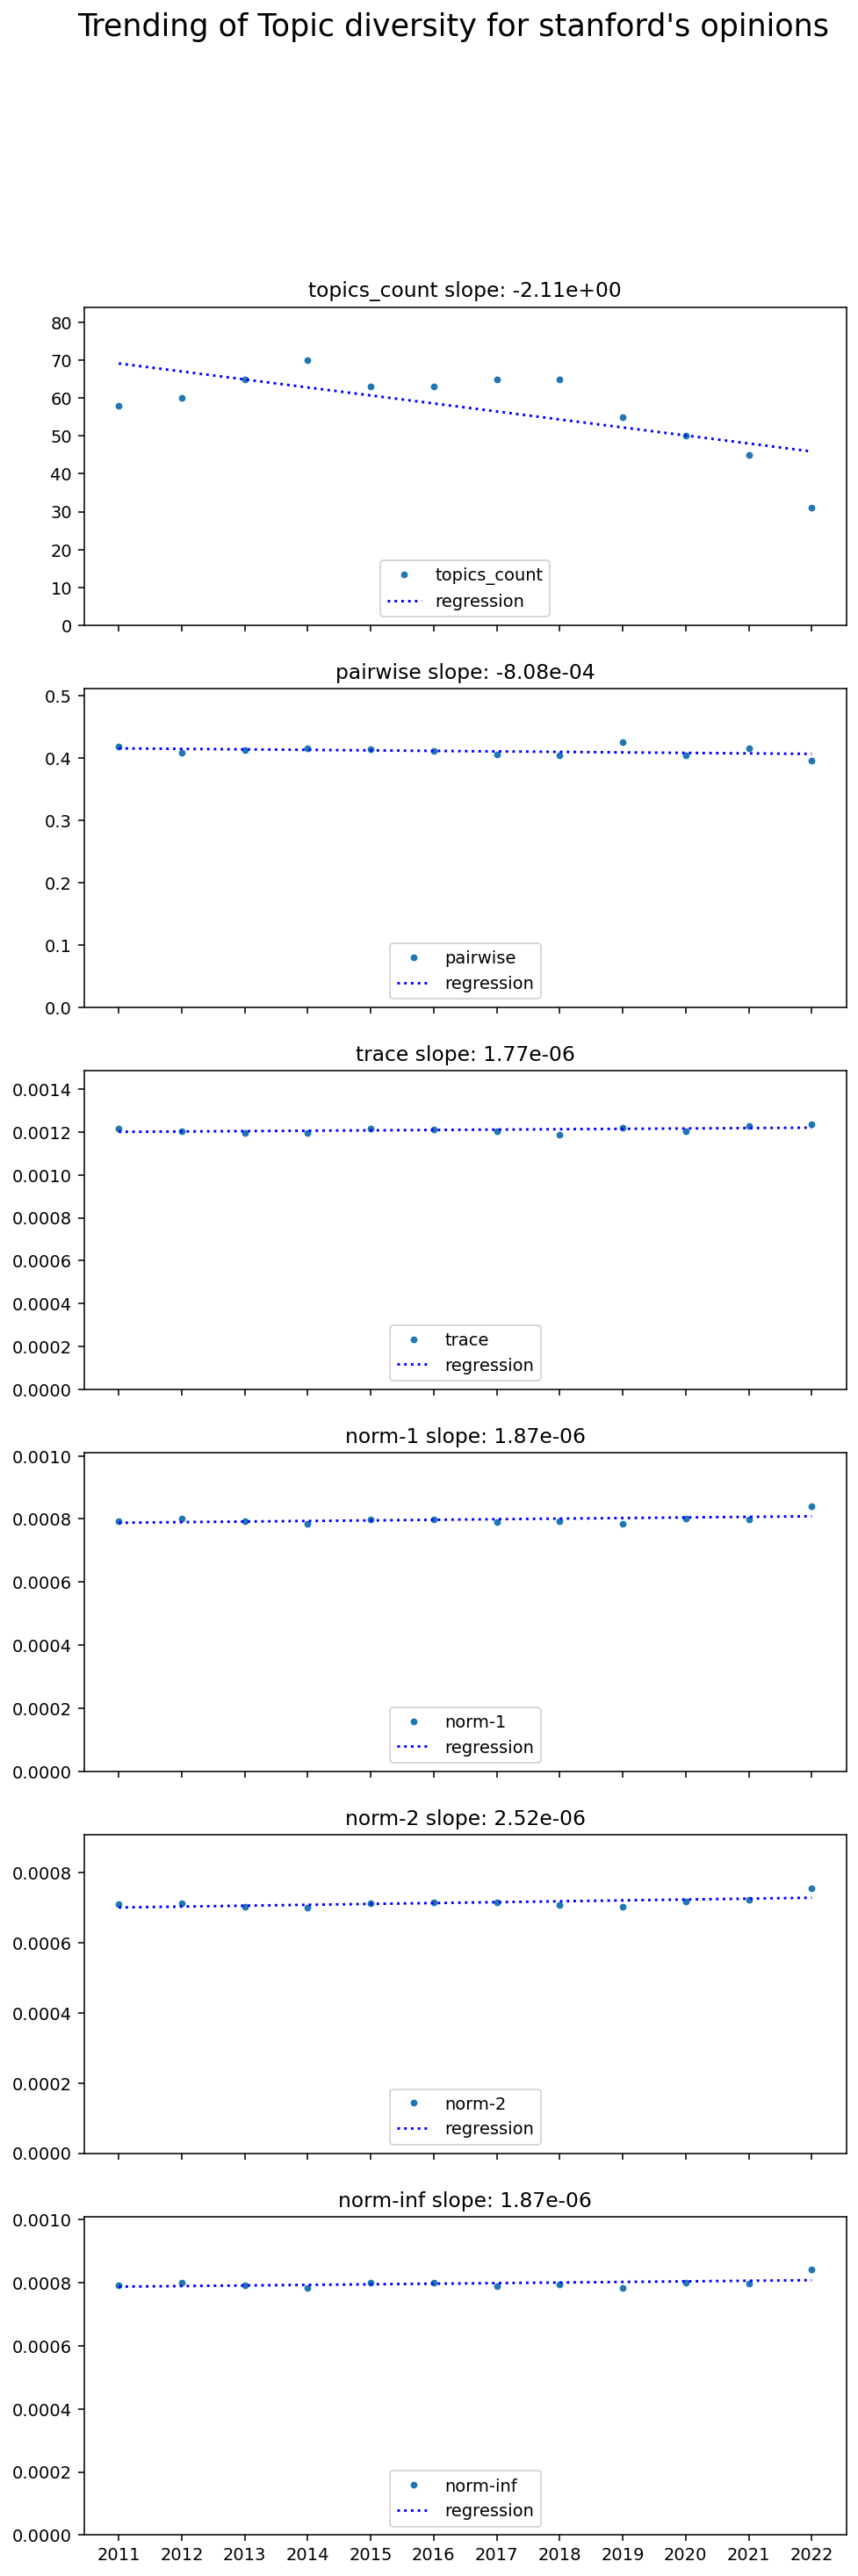

In [57]:
title = "Trending of Topic diversity for {}'s {}".format(
    SCHOOL, SUBJECT
)
columns = ["topics_count", "pairwise", 'trace', 'norm-1', 'norm-2', 'norm-inf']
graph = ourgraphs.showTopicsResults(topics_trend_df, title, columns)
graph.show()

topics_count slope:-2.11189, int:69.11538, r:-0.69696, p:0.01177, se:0.68715, x:range(0, 12)
pairwise slope:-0.00081, int:0.41543, r:-0.37177, p:0.23407, se:0.00064, x:range(0, 12)


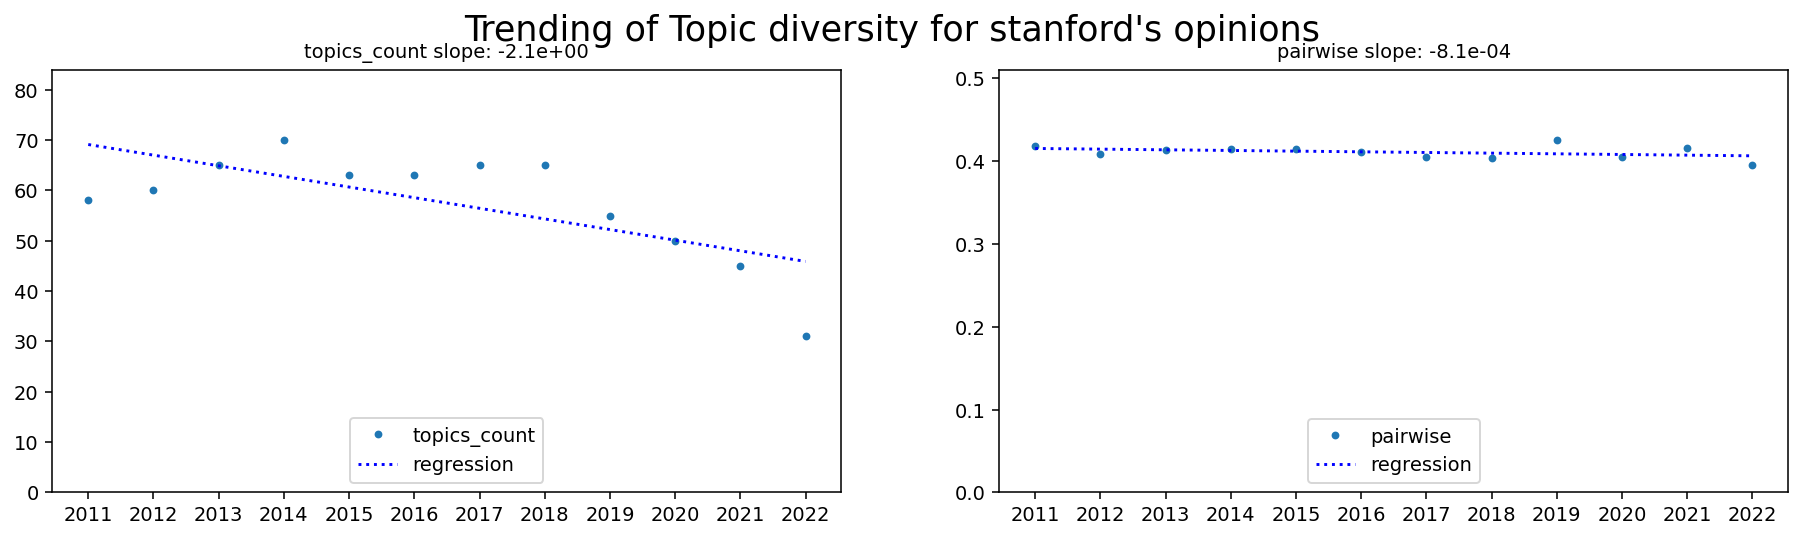

In [58]:
title = "Trending of Topic diversity for {}'s {}\n".format(
    SCHOOL, SUBJECT
)
columns = ["topics_count", "pairwise"]
graph = ourgraphs.showKeyTopicsResults(topics_trend_df, title, columns)
graph.show()

In [59]:
all_topics = topic_model.get_topics()
len(all_topics)

85

### Optionally: remove topic '2' which seems to be an outlier

In [ ]:
del all_topics[3]

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics=all_topics.keys())